In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input/covid19-in-india")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "covid_19_india.csv"          "StatewiseTestingDetails.csv"

In [2]:
library(tidyverse)
library(magrittr)
library(astsa)
library(forecast) 
options(warn = -1)
options(repr.plot.width = 8, repr.plot.height = 8)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




`summarise()` ungrouping output (override with `.groups` argument)



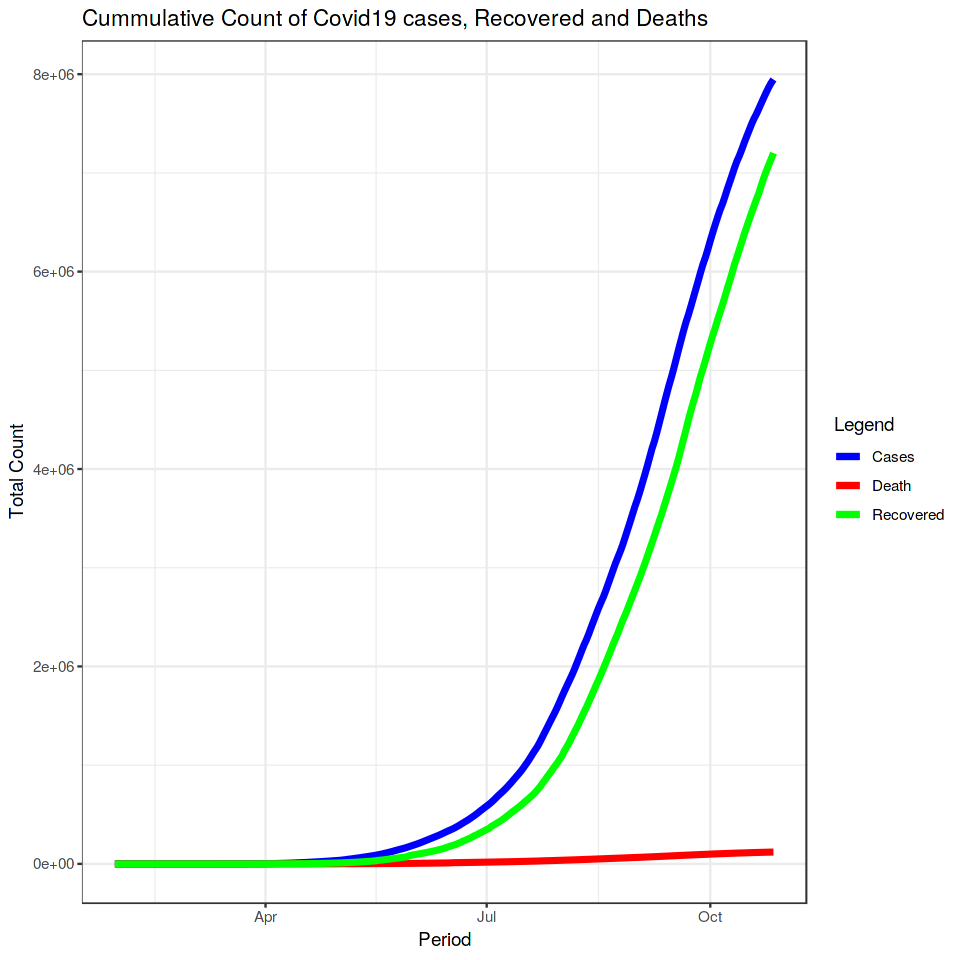

In [3]:
info_cov_india<-read.csv("../input/covid19-in-india/covid_19_india.csv",stringsAsFactors = F)

info_cov_india$Date<-as.Date.character(info_cov_india$Date,format = c("%d/%m/%y"))
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(Date)%>% summarize(cured=sum(Cured),deaths=sum(Deaths),case=sum(Confirmed))
ggplot(info_cov_india1,aes(x=Date))+geom_line(aes(y=case,color="Cases"), size=1.5) + geom_line(aes(y=deaths,color="Death"), size=1.5)+ geom_line(aes(y=cured,color="Recovered"), size=1.5)+theme_bw() +ylab("Total Count")+xlab("Period")+ labs(title="Cummulative Count of Covid19 cases, Recovered and Deaths",color = "Legend")+scale_color_manual(values = c("blue","red","green"))

`summarise()` ungrouping output (override with `.groups` argument)



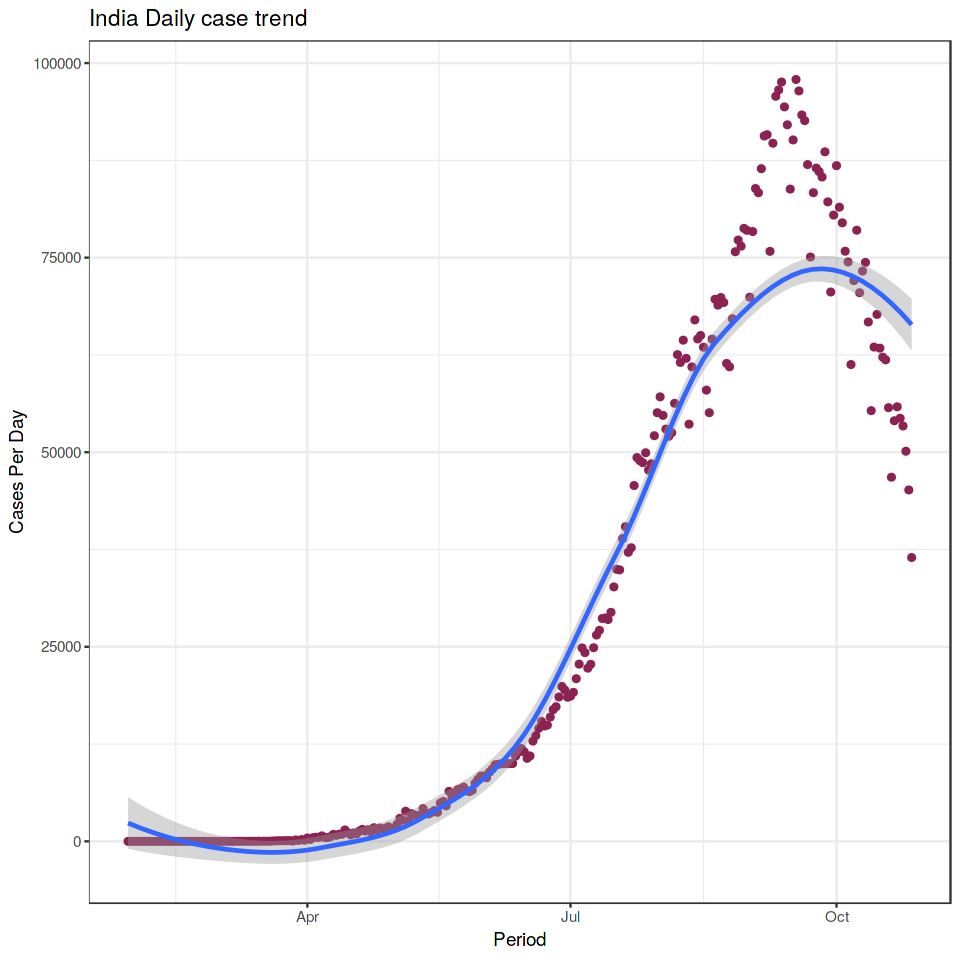

In [4]:
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(Date)%>% summarize(cured=sum(Cured),deaths=sum(Deaths),case=sum(Confirmed))
info_cov_india1<-arrange(info_cov_india1,Date)%>%mutate(per_day_case = c(0,diff(case)))

ggplot(info_cov_india1,aes(x=Date,y=per_day_case))+geom_point(color="violetred4")+geom_smooth(method="loess", formula=y~x)+theme_bw()+xlab("Period")+ylab("Cases Per Day")+labs(title="India Daily case trend")

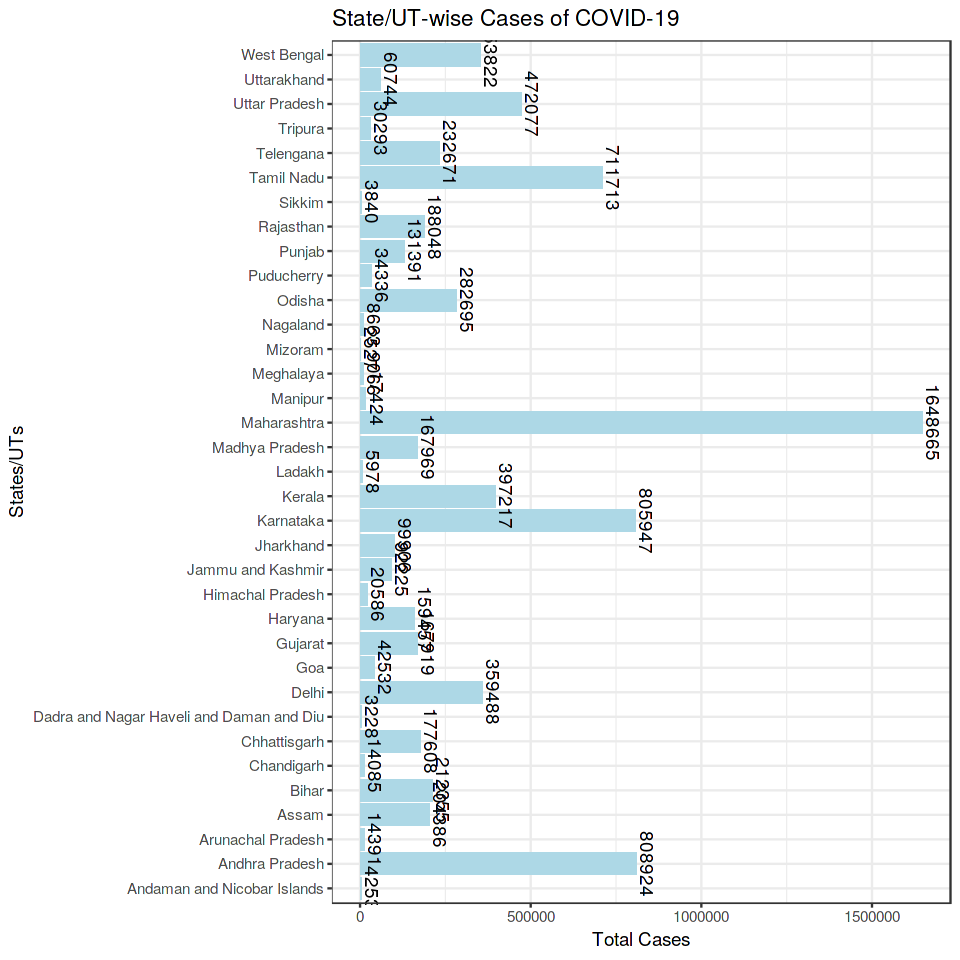

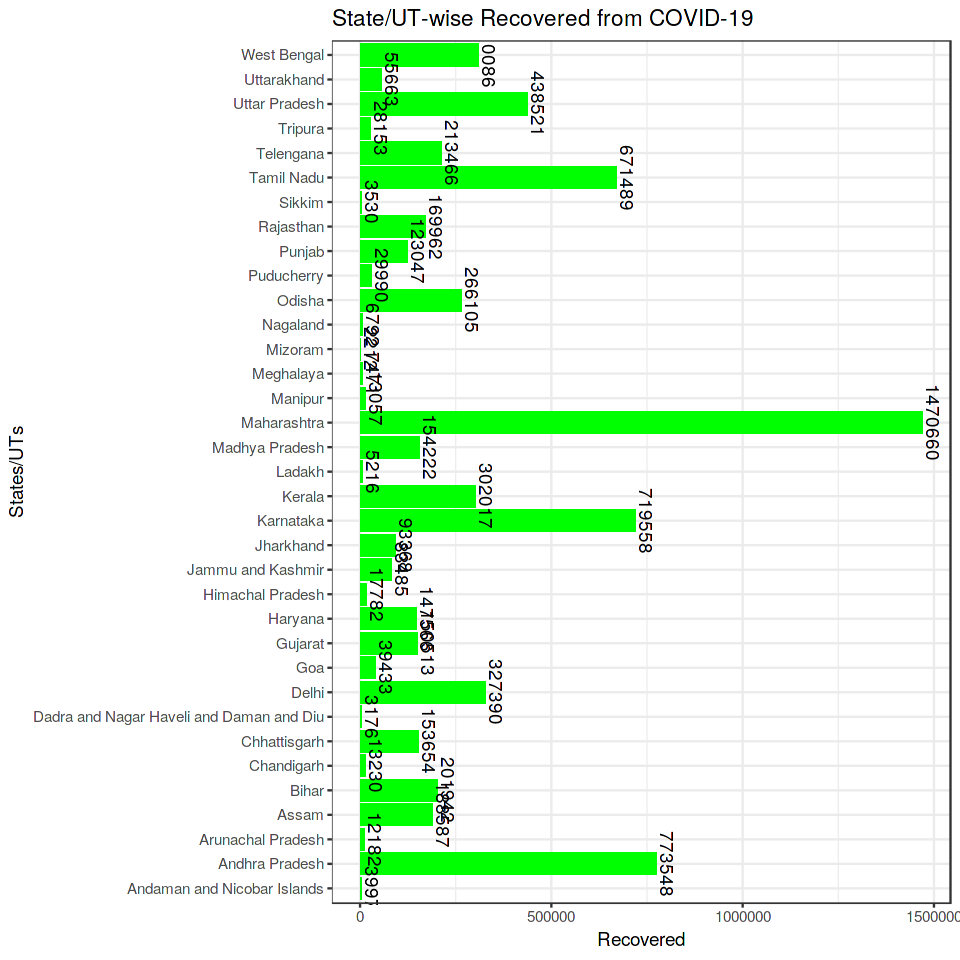

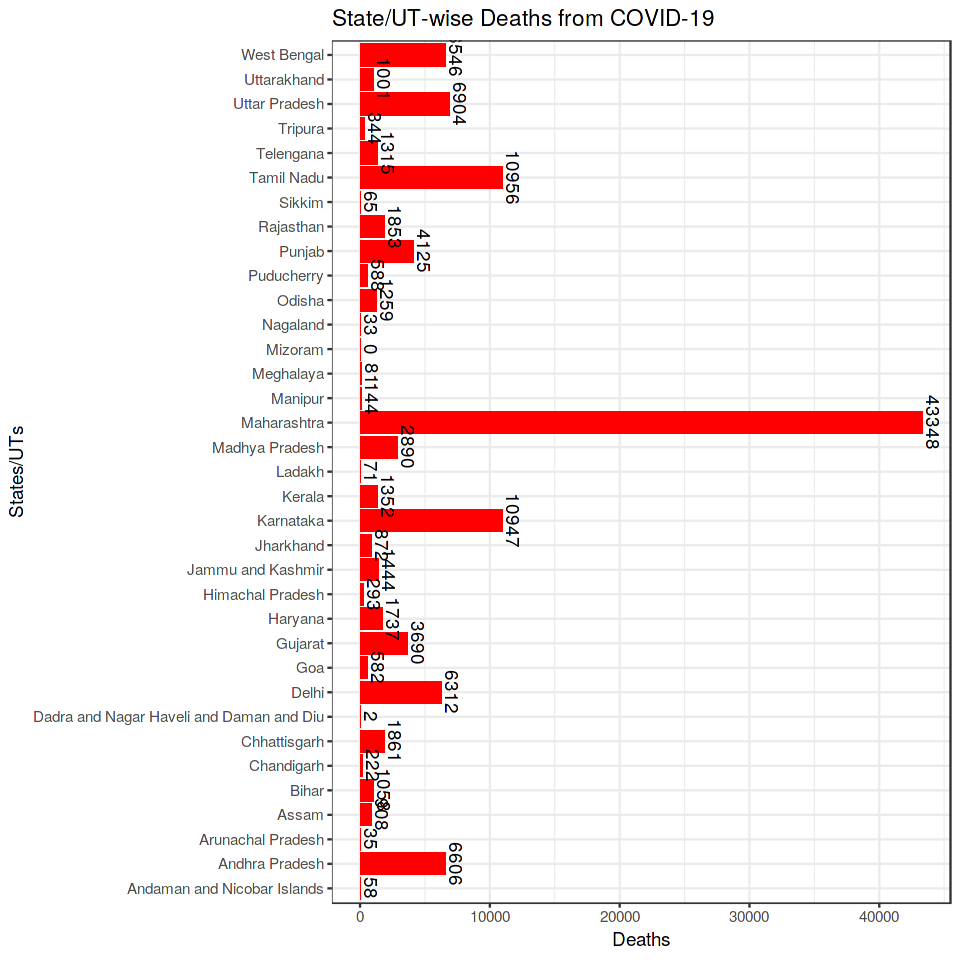

In [5]:
info_cov_india1<-filter(info_cov_india,Date==max(Date))


ggplot(info_cov_india1, aes(x=State.UnionTerritory, y=Confirmed))+geom_col(fill="lightblue")+ theme(axis.text.x=element_text(size=20, angle=90, hjust = 1, vjust = 0.5 ) , plot.background = element_rect( colour = NULL,  size = 20,  linetype = NULL,  color = NULL, fill = NULL, inherit.blank = FALSE)) +xlab("States/UTs")+ylab("Total Cases")+ labs(title="State/UT-wise Cases of COVID-19")+ theme_bw() + geom_text(aes(label=round(Confirmed) ), position=position_dodge(width=1.0),vjust=-0.25,angle=270)+coord_flip()
ggplot(info_cov_india1, aes(x=State.UnionTerritory, y=Cured))+geom_col(fill="green")+ theme(axis.text.x=element_text(size=10, angle=90, hjust = 1, vjust = 0.5 ) , plot.background = element_rect( colour = NULL,  size = 20,  linetype = NULL,  color = NULL, fill = NULL, inherit.blank = FALSE)) +xlab("States/UTs")+ylab("Recovered")+ labs(title="State/UT-wise Recovered from COVID-19")+ theme_bw()+  geom_text(aes(label=round(Cured) ), position=position_dodge(width=1.0),vjust=-0.25,angle=270)+coord_flip()
ggplot(info_cov_india1, aes(x=State.UnionTerritory, y=Deaths))+geom_col(fill="red")+ theme(axis.text.x=element_text(size=10, angle=90, hjust = 1, vjust = 0.5 ) , plot.background = element_rect( colour = NULL,  size = 20,  linetype = NULL,  color = NULL, fill = NULL, inherit.blank = FALSE)) +xlab("States/UTs")+ylab("Deaths")+ labs(title="State/UT-wise Deaths from COVID-19")+ theme_bw()+  geom_text(aes(label=round(Deaths) ), position=position_dodge(width=1.0),vjust=-0.25,angle=270)+coord_flip()

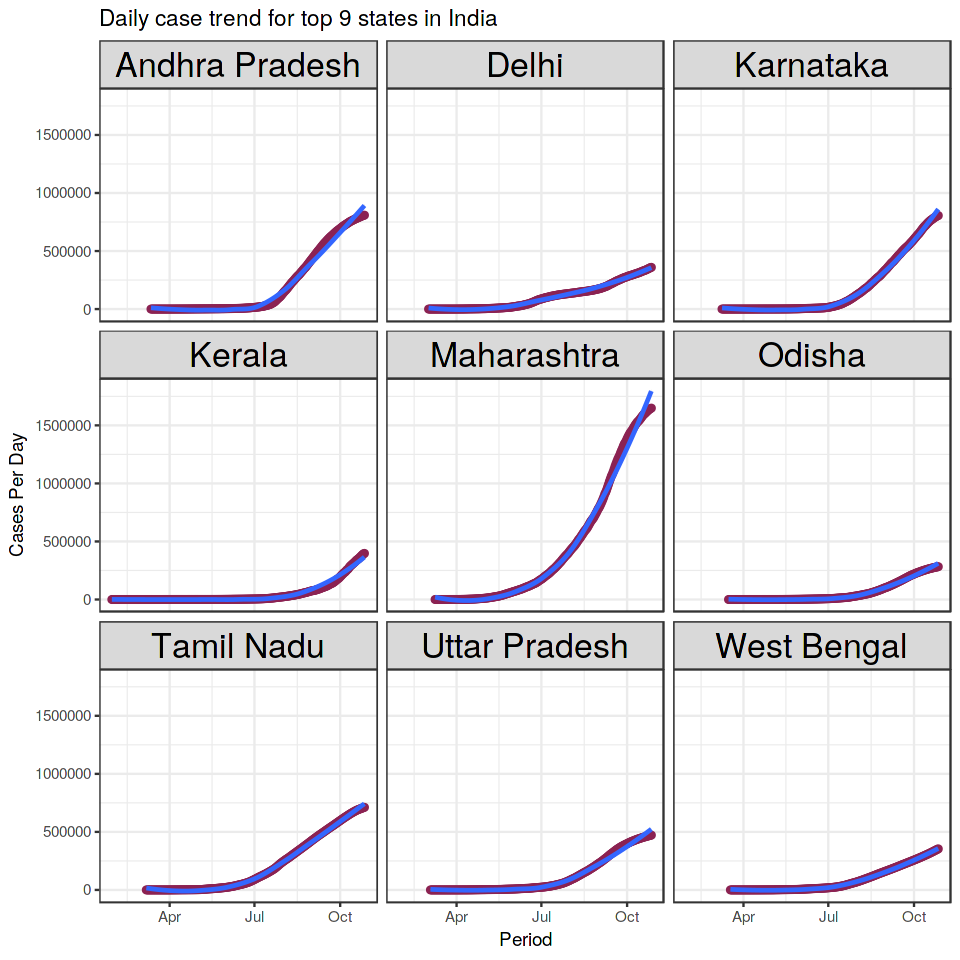

In [6]:
info_cov_india1<-filter(info_cov_india,Date==max(Date))%>%top_n(9,Confirmed)
info_cov_india1<-inner_join(info_cov_india,info_cov_india1,"State.UnionTerritory")
info_cov_india1<-arrange(info_cov_india1,Date.x)%>%group_by(State.UnionTerritory)%>%mutate(per_day_cases = c(0,diff(Confirmed.x)))

ggplot(info_cov_india1,aes(x=Date.x,y=Confirmed.x))+geom_point(color="violetred4")+geom_smooth(method="loess",formula=y~x)+theme_bw()+xlab("Period")+ylab("Cases Per Day")+labs(title="Daily case trend for top 9 states in India")+facet_wrap(~State.UnionTerritory)+theme(strip.text.x = element_text(size = 20, colour = "black"))

`summarise()` ungrouping output (override with `.groups` argument)



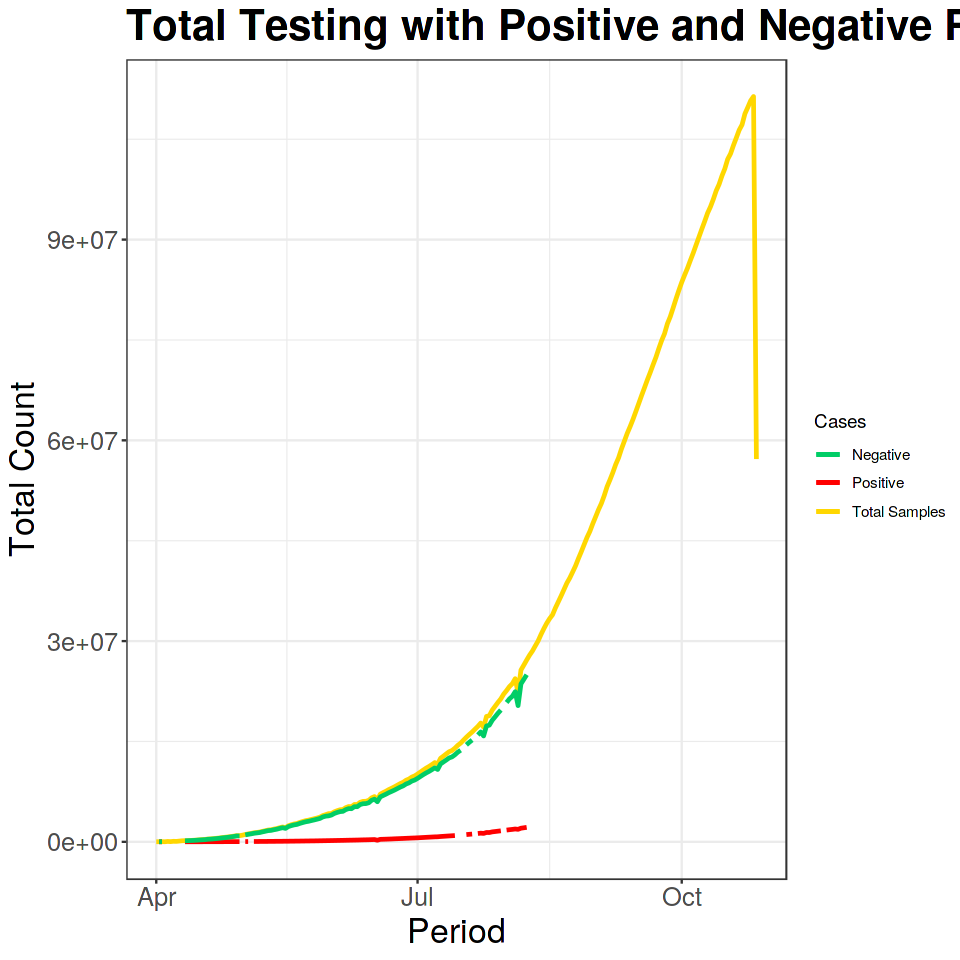

In [7]:
info_test_details_india<-read.csv("../input/covid19-in-india/StatewiseTestingDetails.csv",stringsAsFactors = F)
info_test_details_india[,"NegClean"]<-ifelse(is.na(info_test_details_india$Negative),(info_test_details_india$TotalSamples-info_test_details_india$Positive),info_test_details_india$Negative)

info_test_details_india$Date<-as.Date.character(info_test_details_india$Date,format = c("%Y-%m-%d"))

info_test_details_india1<-arrange(info_test_details_india,Date)%>%group_by(Date)%>% summarize(Total=sum(TotalSamples),Negative=sum(NegClean),Positive=sum(Positive))

ggplot(info_test_details_india1,aes(x=Date))+geom_line(aes(y=Total,color="Total Samples"),size=1) + geom_line(aes(y=Positive,color="Positive"), size=1)+ geom_line(aes(y=Negative,color="Negative"), size=1)+theme_bw() +ylab("Total Count")+xlab("Period")+ labs(title="Total Testing with Positive and Negative Results",color = "Cases")+scale_color_manual(values = c("springgreen3","red","gold"))+theme(axis.title=element_text(size=20),axis.text=element_text(size=15),plot.title = element_text(face = "bold",size=25))
# 
# ggplot(info_test_details_india1,aes(x=Date))+geom_area(aes(y=Total,fill="Total Samples"),position = "stack",alpha=0.5) + geom_area(aes(y=Positive,fill="Positive"),position = "stack",alpha=0.5)+ geom_area(aes(y=Negative,fill="Negative"),position = "stack",alpha=0.5)+theme_bw() +ylab("Total Count")+xlab("Period")+ labs(title="Total Testing with Positive and Negative Results",fill = "Cases")+scale_fill_manual(values = c("springgreen3","red","gold"))

`summarise()` ungrouping output (override with `.groups` argument)



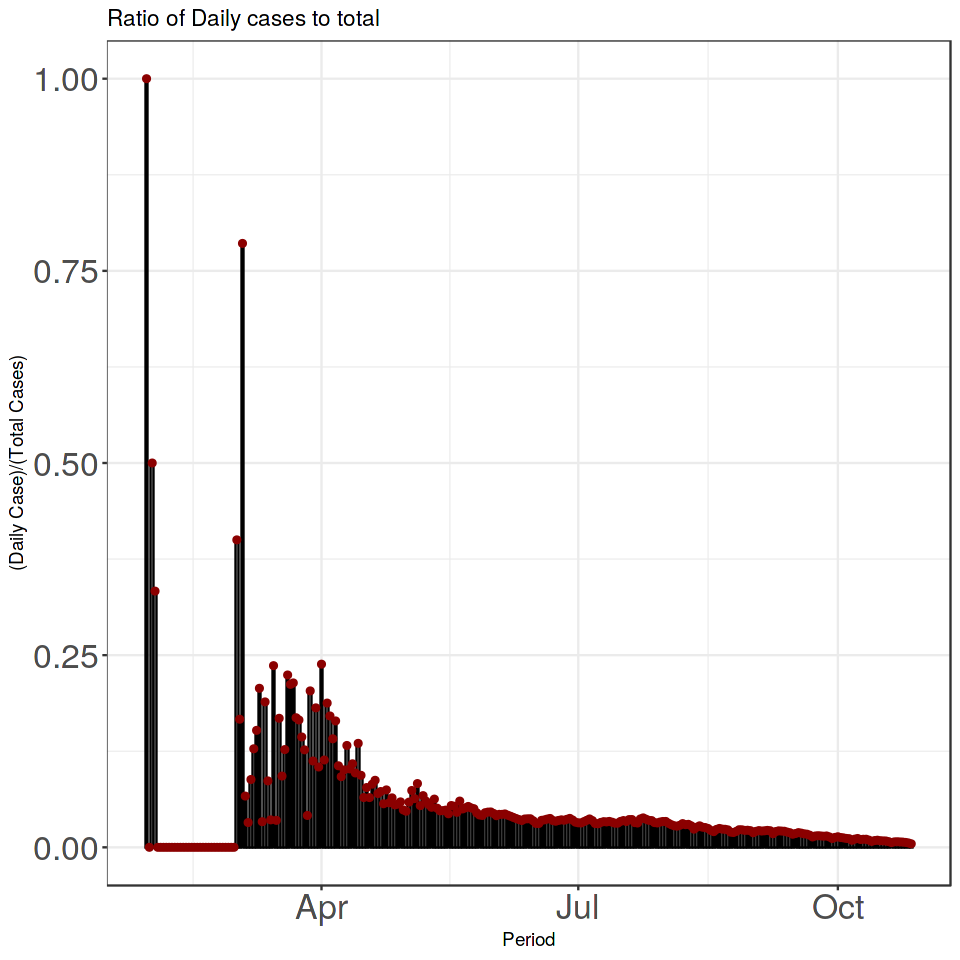

In [8]:
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(Date)%>% summarize(cured=sum(Cured),deaths=sum(Deaths),case=sum(Confirmed))%>%mutate(per_day_cases=c(0,diff(case)),per_day_deaths=c(0,diff(deaths)),per_day_cured=c(0,diff(cured)))

info_cov_india1$per_day_cases<-ifelse(info_cov_india1$Date==min(info_cov_india1$Date),info_cov_india1$case,info_cov_india1$per_day_cases)
info_cov_india1$per_day_deaths<-ifelse(info_cov_india1$Date==min(info_cov_india1$Date),info_cov_india1$deaths,info_cov_india1$per_day_deaths)
info_cov_india1$per_day_cured<-ifelse(info_cov_india1$Date==min(info_cov_india1$Date),info_cov_india1$cured,info_cov_india1$per_day_cured)
info_cov_india1%<>%mutate(rate_case=(per_day_cases/case),rate_death = (per_day_deaths/deaths),rate_cure = (per_day_cured/cured))

ggplot(info_cov_india1,aes(x=Date))+geom_col(aes(y=rate_case),color="black",fill="gray70")+ geom_point(aes(y=rate_case),color="red4") +theme_bw()+theme(axis.text.y=element_text(size=20),axis.text.x=element_text(size=20),legend.position = "none") +ylab("(Daily Case)/(Total Cases)")+xlab("Period")+ labs(title="Ratio of Daily cases to total")

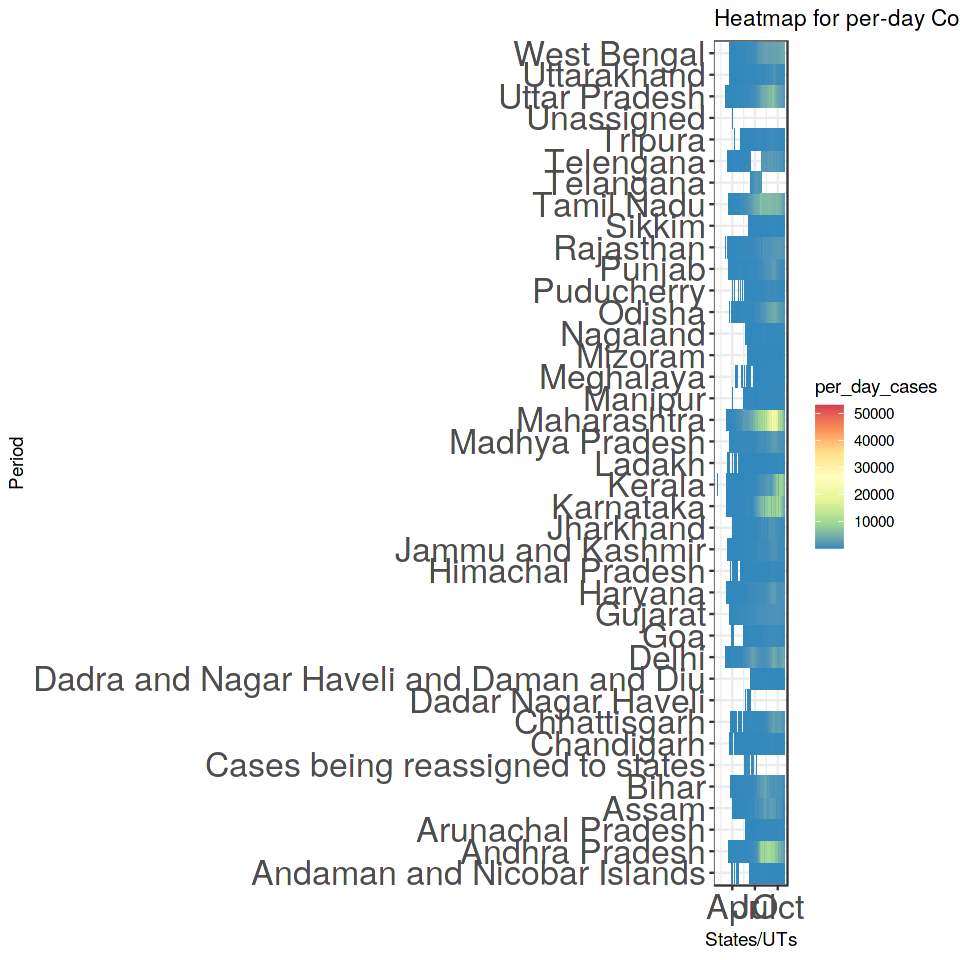

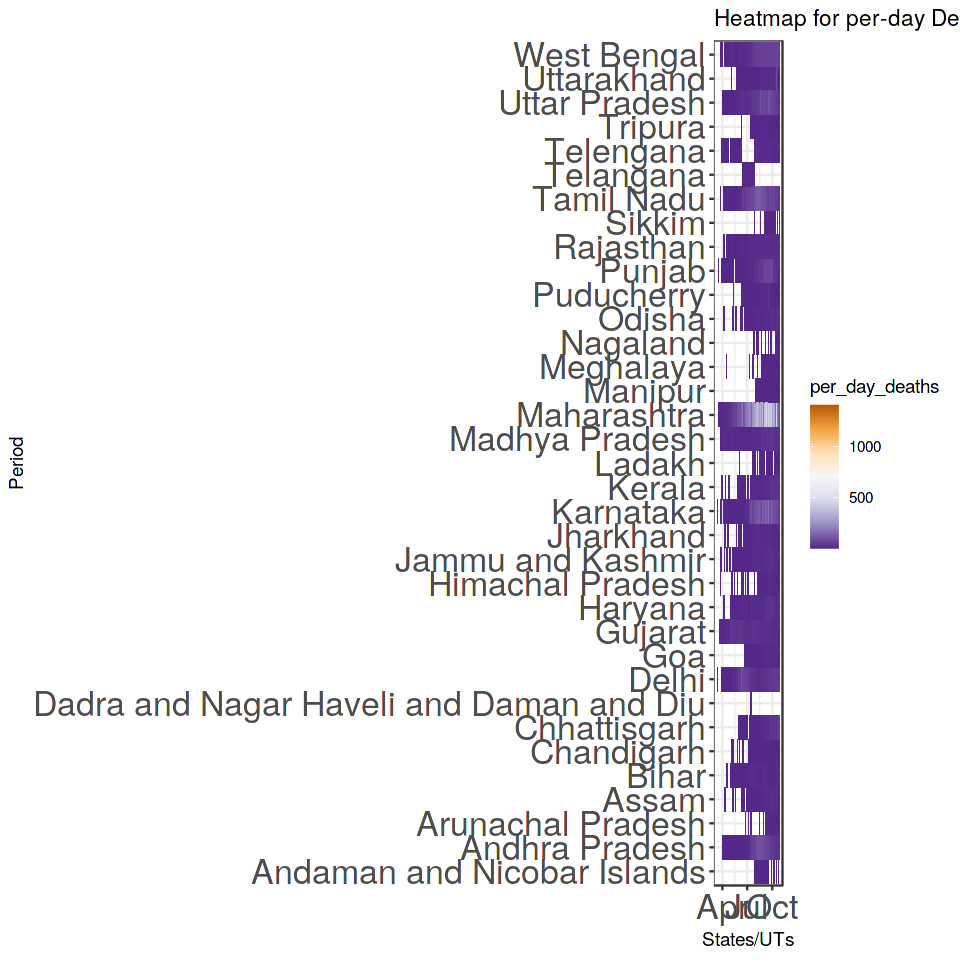

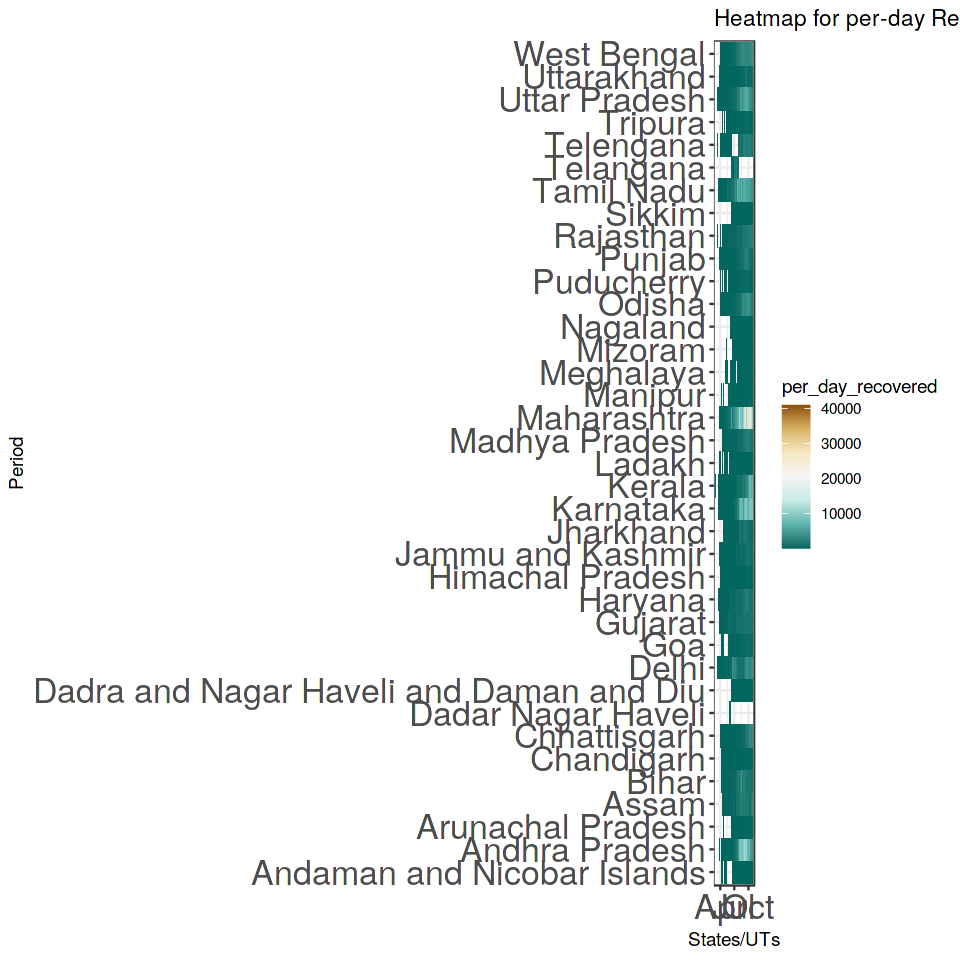

In [9]:
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(State.UnionTerritory)%>%mutate(per_day_cases = c(0,diff(Confirmed)),per_day_deaths = c(0,diff(Deaths)),per_day_recovered = c(0,diff(Cured)))

ggplot(filter(info_cov_india1,per_day_cases>0),aes(x=Date,y=State.UnionTerritory,fill=per_day_cases))+geom_tile()+scale_fill_distiller(palette = "Spectral")+xlab("States/UTs")+ylab("Period")+ labs(title="Heatmap for per-day Covid-19 cases") + theme_bw()+theme(axis.text.y=element_text(size=20),axis.text.x=element_text(size=20))

ggplot(filter(info_cov_india1,per_day_deaths>0),aes(x=Date,y=State.UnionTerritory,fill=per_day_deaths))+geom_tile()+ scale_fill_distiller(palette = "PuOr")+xlab("States/UTs")+ylab("Period")+ labs(title="Heatmap for per-day Deaths") + theme_bw()+theme(axis.text.y=element_text(size=20),axis.text.x=element_text(size=20))

ggplot(filter(info_cov_india1,per_day_recovered>0),aes(x=Date,y=State.UnionTerritory,fill=per_day_recovered))+geom_tile()+scale_fill_distiller(palette = "BrBG") +xlab("States/UTs")+ylab("Period")+ labs(title="Heatmap for per-day Recovered") + theme_bw()+theme(axis.text.y=element_text(size=20),axis.text.x=element_text(size=20))


`summarise()` ungrouping output (override with `.groups` argument)



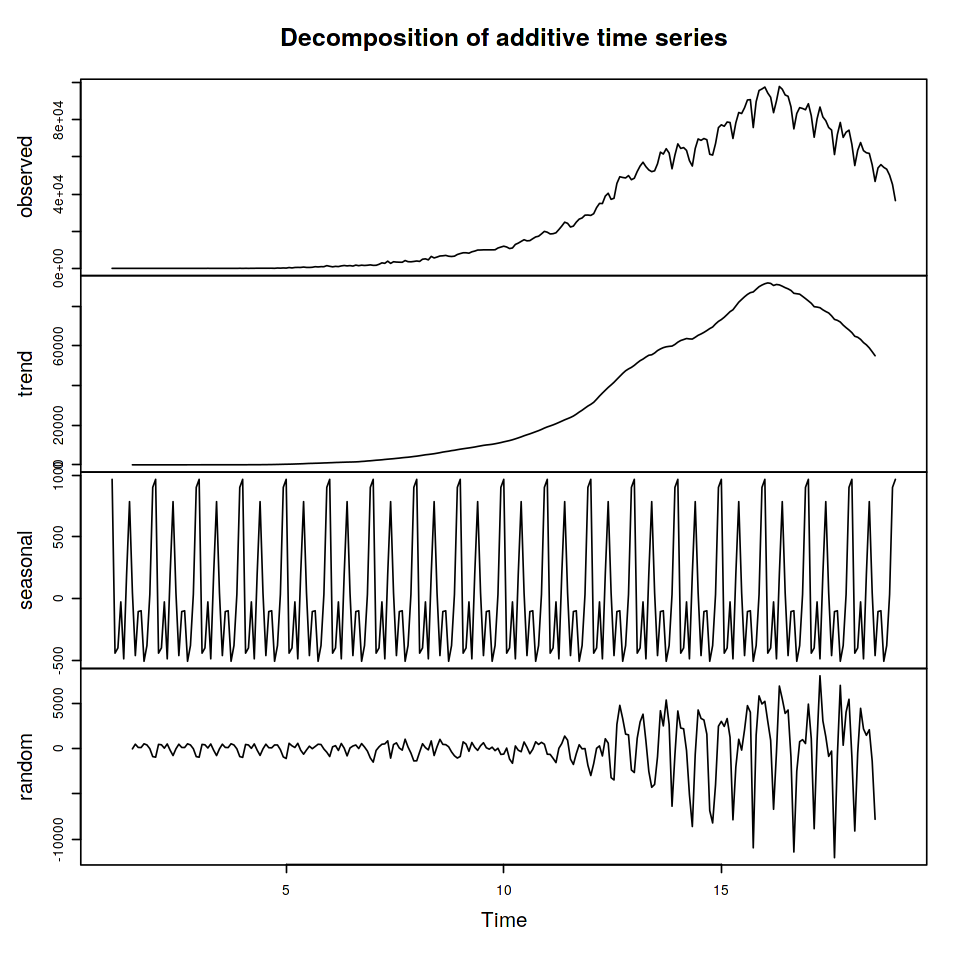

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(Date)%>% summarize(cured=sum(Cured),deaths=sum(Deaths),case=sum(Confirmed))

ts.info_cov_india1<-ts(diff(info_cov_india1$case),     
           start = c(1),
           frequency = 15)

decompose.ts.info_cov_india1 <- decompose(ts.info_cov_india1)
plot(decompose.ts.info_cov_india1)

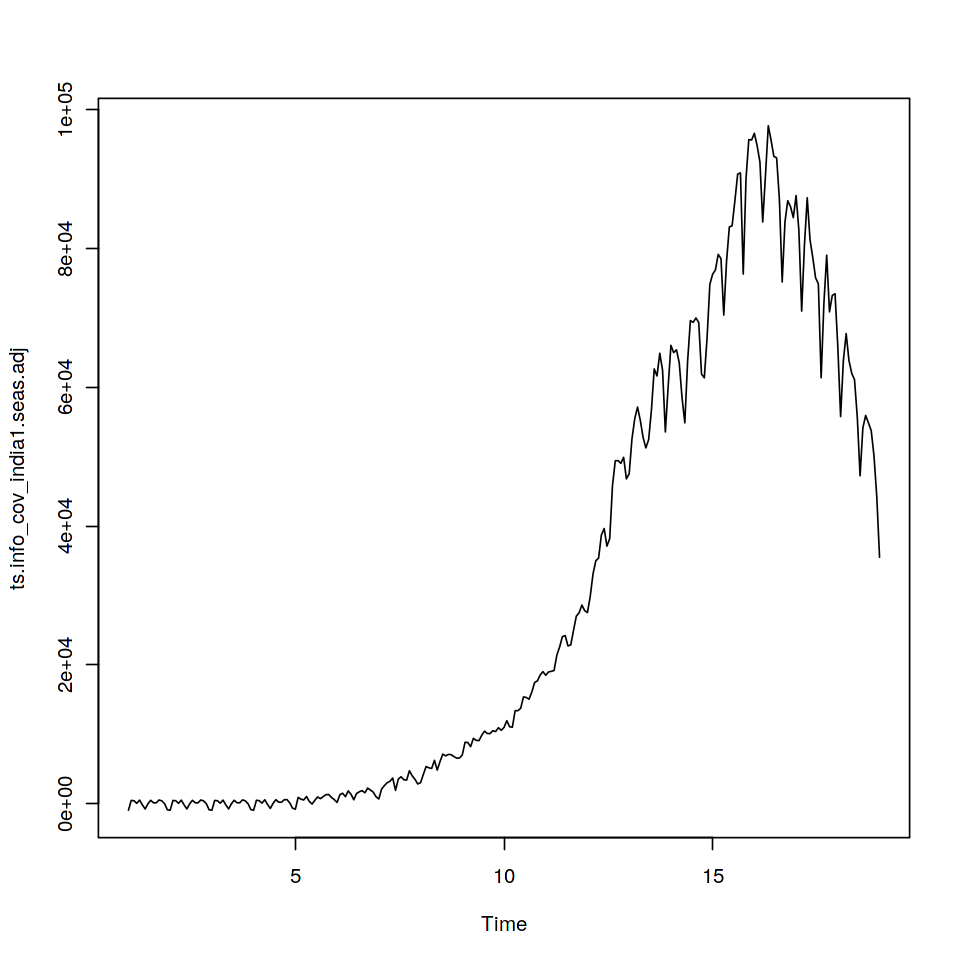

In [11]:
ts.info_cov_india1.seas.adj <- ts.info_cov_india1 - decompose.ts.info_cov_india1$seasonal
plot(ts.info_cov_india1.seas.adj)


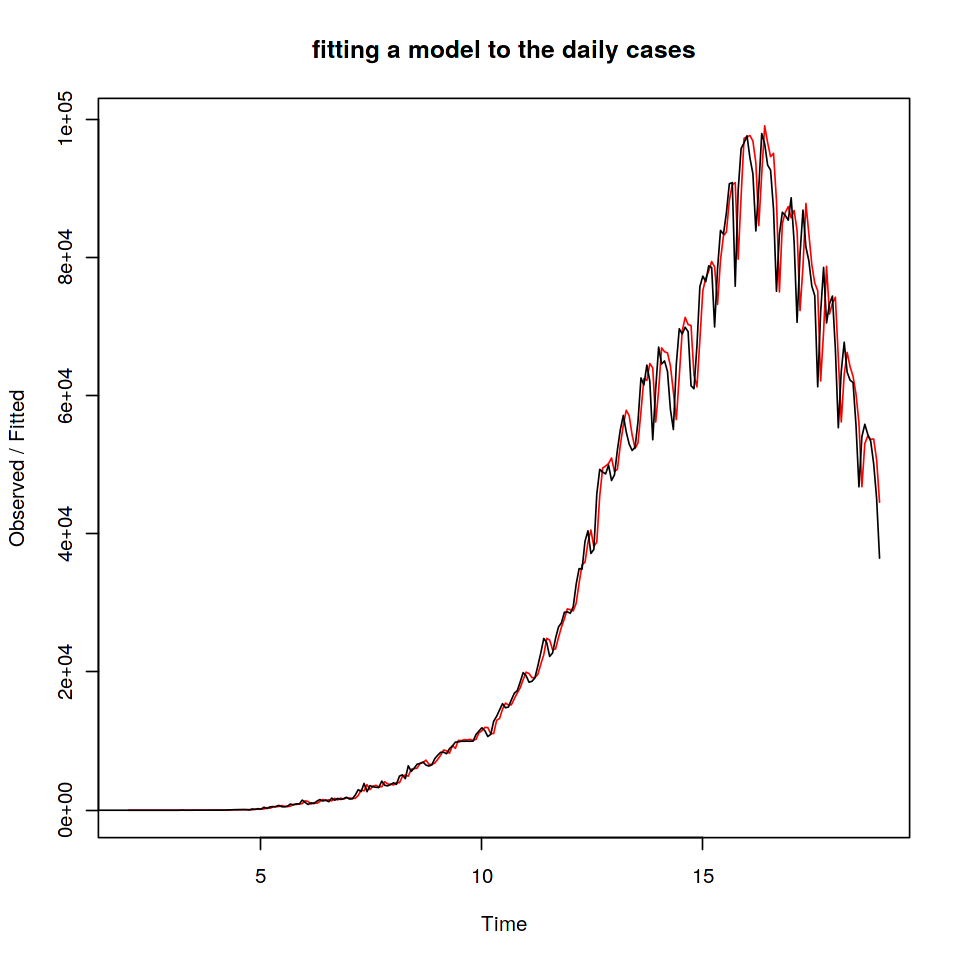

In [12]:
fitted_model<-HoltWinters(ts.info_cov_india1)
plot(fitted_model,main="fitting a model to the daily cases")


	Box-Ljung test

data:  forecast.India.total.cases$residuals
X-squared = 479.2, df = 20, p-value < 2.2e-16


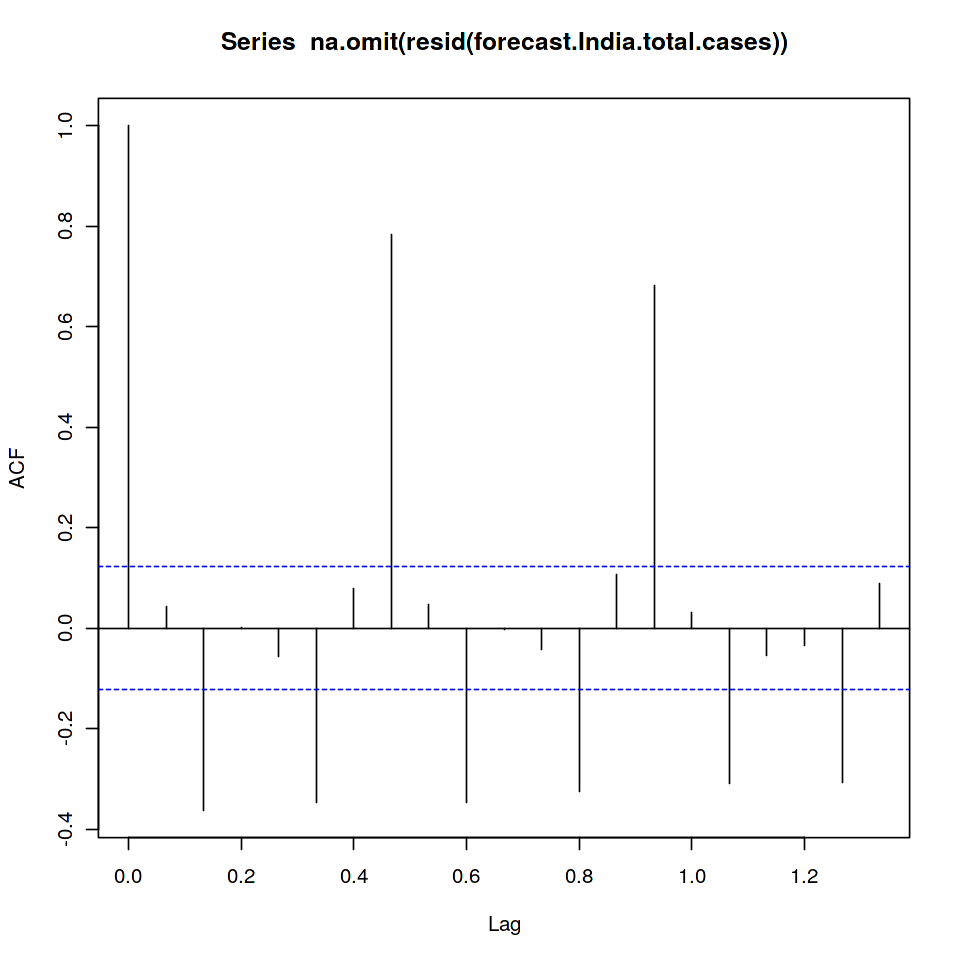

In [13]:
forecast.India.total.cases<-forecast(fitted_model,10)
acf(na.omit(resid(forecast.India.total.cases)), lag.max=20)

Box.test(forecast.India.total.cases$residuals, lag=20, type="Ljung-Box")

Day,Point Forecast
<date>,<dbl>
2020-10-28,34178.93
2020-10-29,34484.60
2020-10-30,34581.01
2020-10-31,32306.37
2020-11-01,31791.94
2020-11-02,31343.93
2020-11-03,28343.04
2020-11-04,26516.01
2020-11-05,26320.30


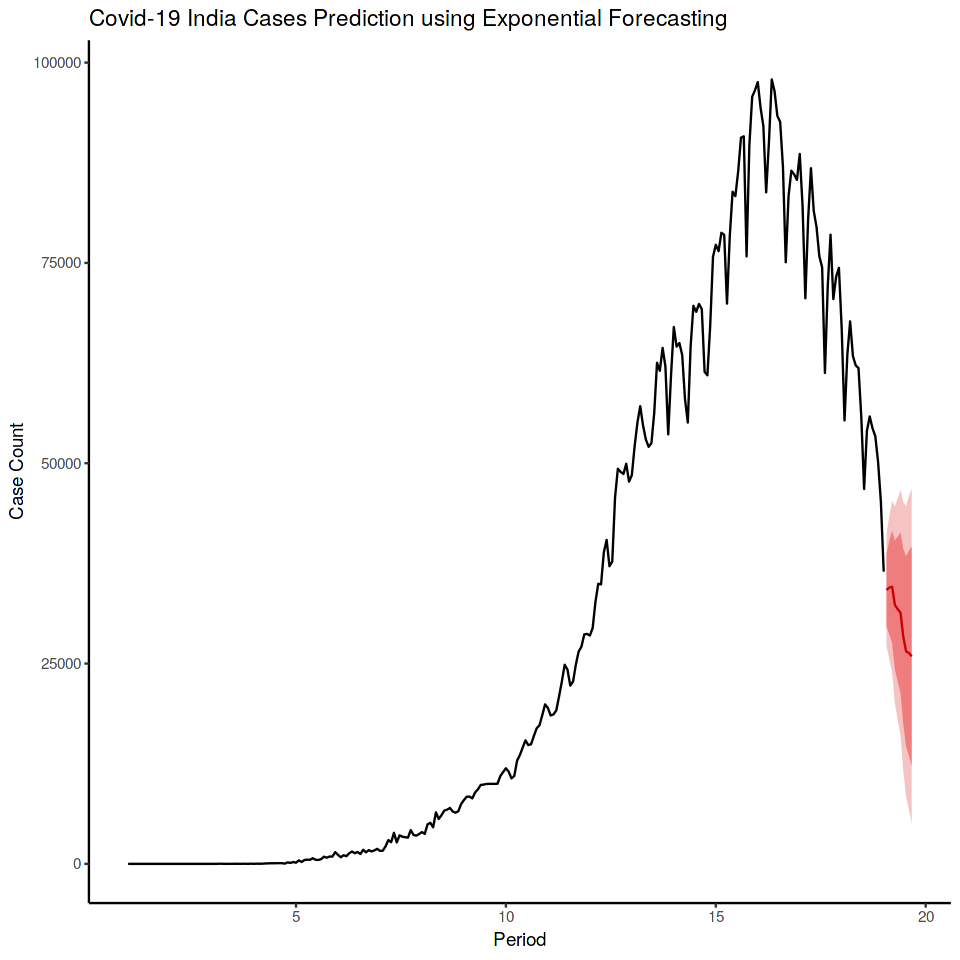

In [14]:
autoplot(forecast.India.total.cases,fcol = "red") + geom_forecast(h=10) + theme_classic()+labs(title="Covid-19 India Cases Prediction using Exponential Forecasting")+xlab("Period")+ylab("Case Count")

given.last.date<-max(info_cov_india1$Date)
given.start.date<-min(info_cov_india1$Date)


#plot(forecast.India.total.cases, xaxt='n',main="Covid-19 India Cases Prediction using Exponential Forecasting",fcol="red")
#axis(1, at=seq(1, as.numeric(given.last.date-given.start.date), by=1), las=2, labels=seq(given.start.date, given.last.date, length.out=as.numeric(given.last.date-given.start.date) ))

forecast.India.total.cases%<>%as_tibble()
forecast.India.total.cases[,"Day"]<-given.last.date+as.numeric(row.names(forecast.India.total.cases))
forecast.India.total.cases<-as.data.frame(forecast.India.total.cases[,c(6,1)])
forecast.India.total.cases

In [15]:
info_cov_india1<-arrange(info_cov_india,Date)%>%group_by(Date)%>% summarize(cured=sum(Cured),deaths=sum(Deaths),case=sum(Confirmed))

ts.info_cov_india1<-ts(diff(info_cov_india1$case))

`summarise()` ungrouping output (override with `.groups` argument)



In [16]:
Box.test(ts.info_cov_india1, lag = log(length(ts.info_cov_india1)))


	Box-Pierce test

data:  ts.info_cov_india1
X-squared = 1306, df = 5.6021, p-value < 2.2e-16


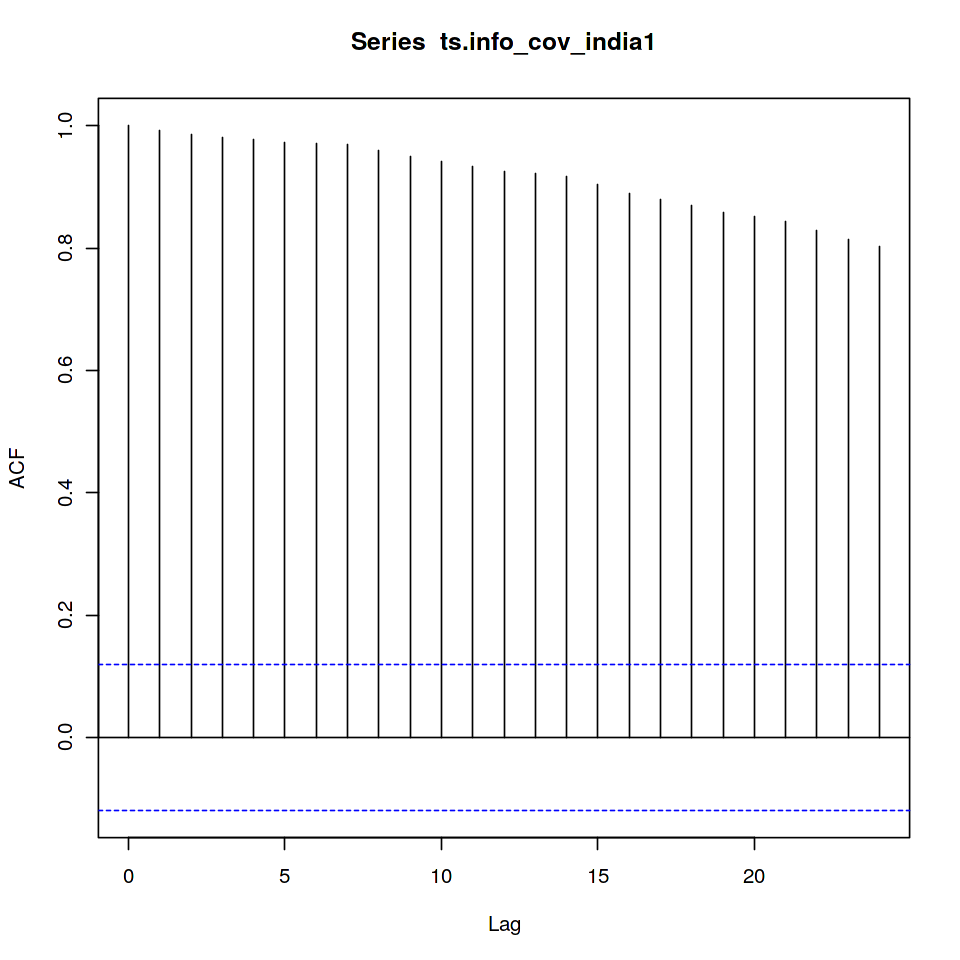

In [17]:
acf(ts.info_cov_india1)

In [18]:
#without approximation
auto.arima(ts.info_cov_india1,ic="aic",approximation=F)

Series: ts.info_cov_india1 
ARIMA(1,1,2) 

Coefficients:
          ar1     ma1      ma2
      -0.2659  0.2803  -0.4268
s.e.   0.1220  0.1082   0.0559

sigma^2 estimated as 10362655:  log likelihood=-2562.62
AIC=5133.24   AICc=5133.39   BIC=5147.64

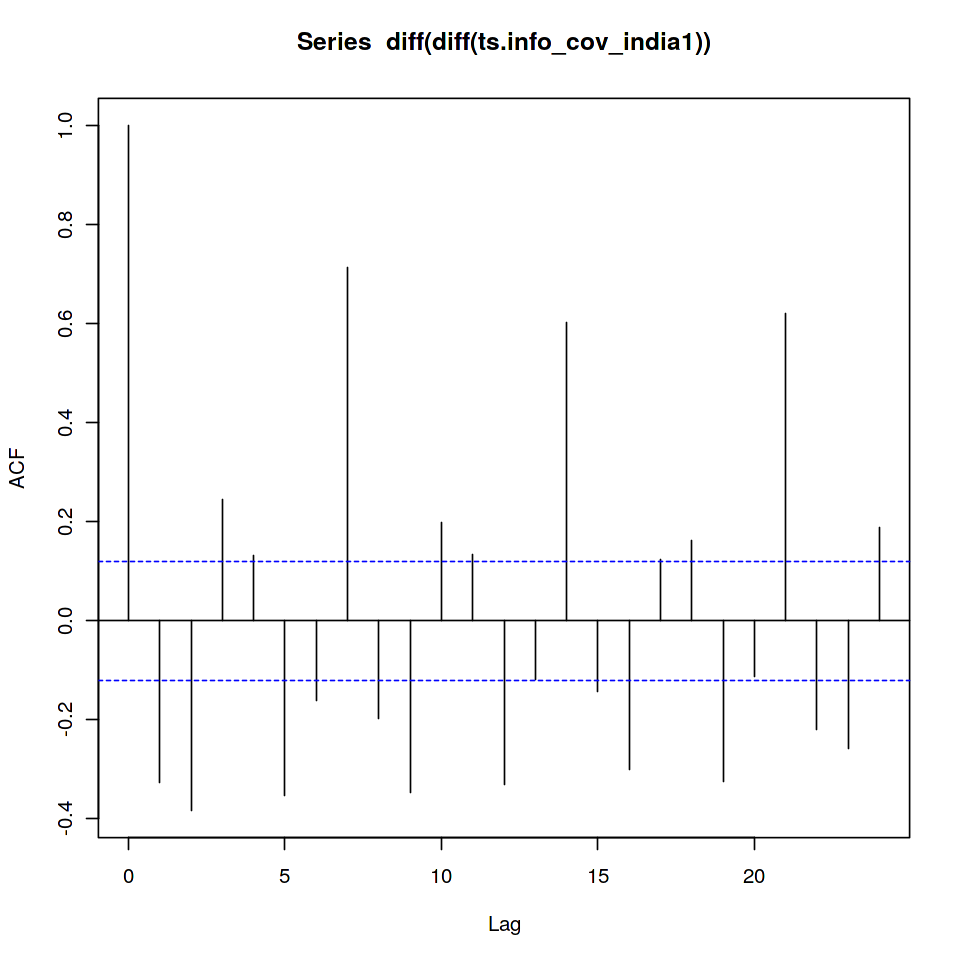

In [19]:
acf(diff(diff(ts.info_cov_india1)))


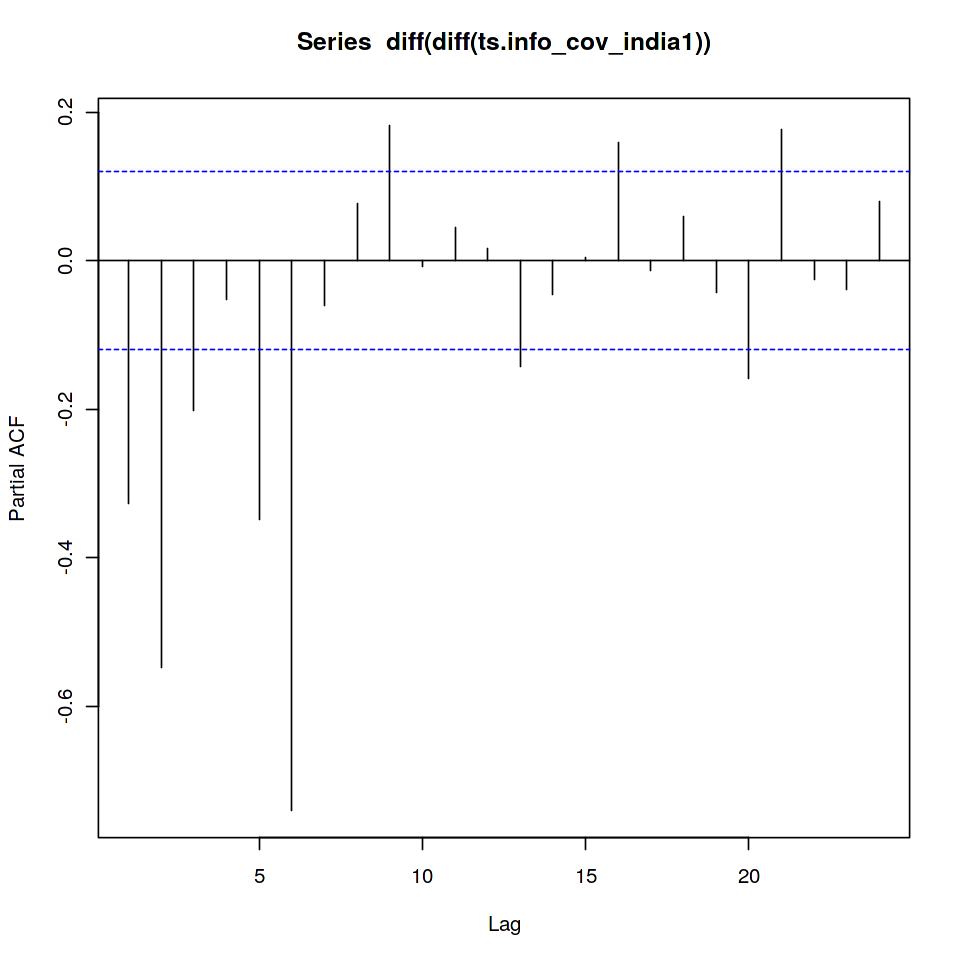

In [20]:
pacf(diff(diff(ts.info_cov_india1)))

In [21]:
d=2
DD=0
#assumption there is seasonality after 15 days
per=15
for(p in 1:5){
  for(q in 1:4){
    for(i in 1:2){
      for(j in 1:1){
        if(p+d+q+i+DD+j<=10){
          model<-arima(x=ts.info_cov_india1, order = c((p-1),d,(q-1)), seasonal = list(order=c((i-1),DD,(j-1)), period=per))
          pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2) 
          cat(p-1,d,q-1,i-1,DD,j-1,per, 'AIC=', model$aic, ' SSE=',sse,' p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}

0 2 0 0 0 0 15 AIC= 5337.534  SSE= 6477059613  p-VALUE= 0 
0 2 0 1 0 0 15 AIC= 5333.536  SSE= 6325710402  p-VALUE= 0 
0 2 1 0 0 0 15 AIC= 5159.53  SSE= 3280741107  p-VALUE= 8.892886e-14 
0 2 1 1 0 0 15 AIC= 5161.116  SSE= 3275204830  p-VALUE= 5.107026e-14 
0 2 2 0 0 0 15 AIC= 5160.988  SSE= 3274136945  p-VALUE= 6.916689e-14 
0 2 2 1 0 0 15 AIC= 5157.281  SSE= 3186287677  p-VALUE= 3.023137e-13 
0 2 3 0 0 0 15 AIC= 5076.534  SSE= 2360954881  p-VALUE= 0.03353771 
0 2 3 1 0 0 15 AIC= 5077.989  SSE= 2355670594  p-VALUE= 0.02384878 
1 2 0 0 0 0 15 AIC= 5309.258  SSE= 5785179424  p-VALUE= 0 
1 2 0 1 0 0 15 AIC= 5309.851  SSE= 5753309272  p-VALUE= 0 
1 2 1 0 0 0 15 AIC= 5161.422  SSE= 3279513603  p-VALUE= 7.993606e-14 
1 2 1 1 0 0 15 AIC= 5162.776  SSE= 3271000748  p-VALUE= 3.630429e-14 
1 2 2 0 0 0 15 AIC= 5142.299  SSE= 3027808926  p-VALUE= 4.57837e-09 
1 2 2 1 0 0 15 AIC= 5144.262  SSE= 3027501156  p-VALUE= 5.784728e-09 
1 2 3 0 0 0 15 AIC= 5077.691  SSE= 2352445369  p-VALUE= 0.008111839 
2


	Box-Ljung test

data:  forecast.India.total.cases$residuals
X-squared = 276.87, df = 20, p-value < 2.2e-16


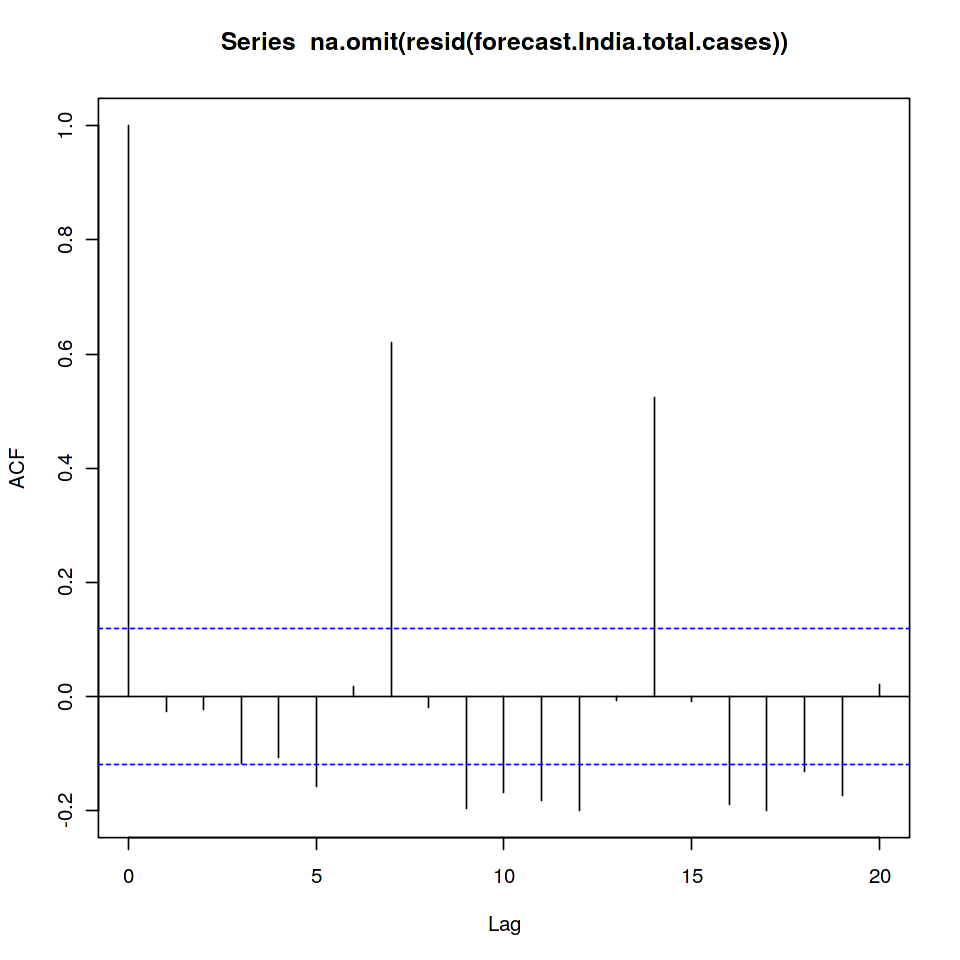

In [22]:
fitted_model<-arima(ts.info_cov_india1,order=c(0,2,3),seasonal = list(order=c(1,0,0), period=per))


forecast.India.total.cases<-forecast(fitted_model,10)
acf(na.omit(resid(forecast.India.total.cases)), lag.max=20)

Box.test(forecast.India.total.cases$residuals, lag=20, type="Ljung-Box")

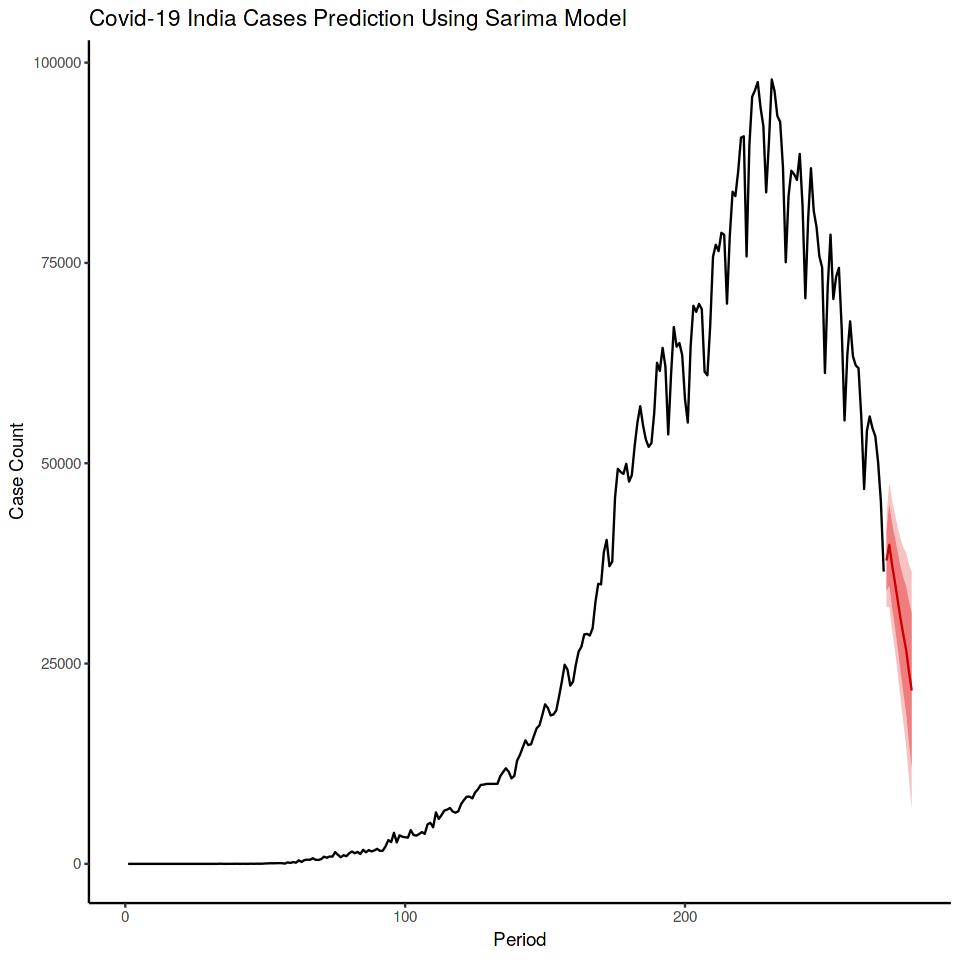

Day,Point Forecast
<date>,<dbl>
2020-10-28,37856.73
2020-10-29,39814.08
2020-10-30,37272.44
2020-10-31,35176.57
2020-11-01,32914.73
2020-11-02,30610.18
2020-11-03,28608.94
2020-11-04,26753.03
2020-11-05,24051.85


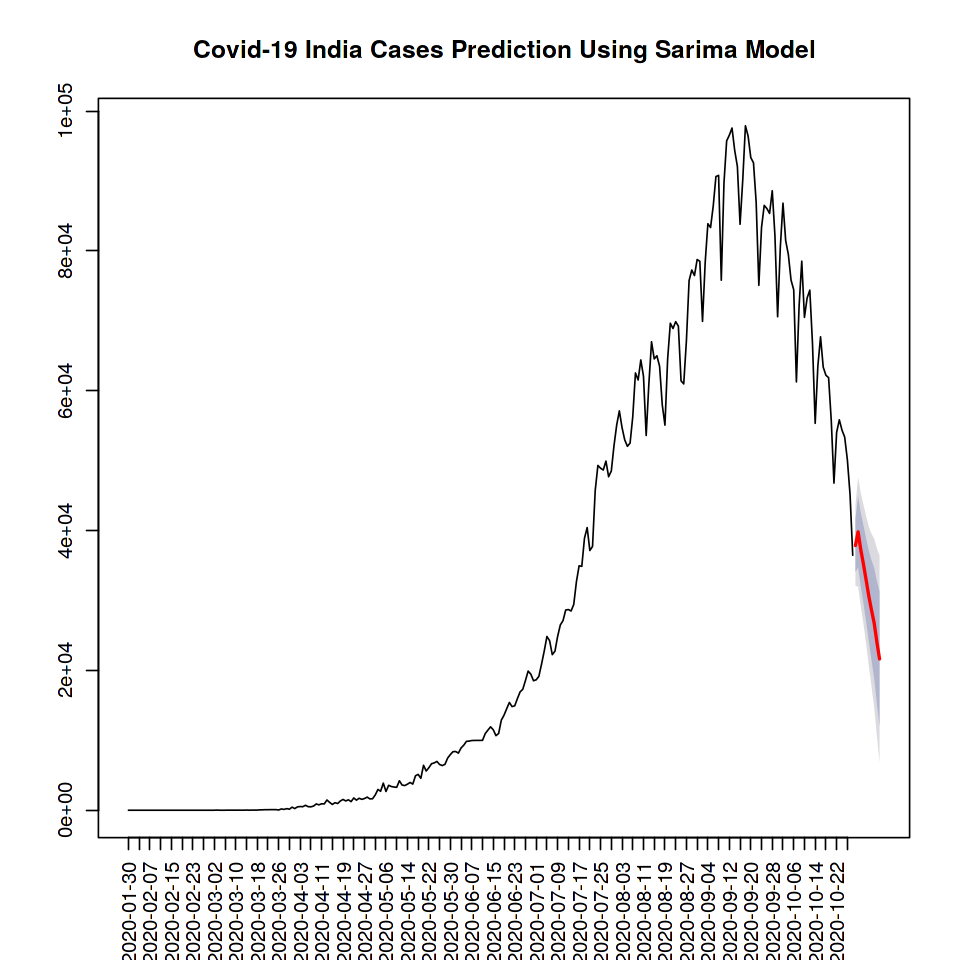

In [23]:
autoplot(forecast.India.total.cases,fcol = "red") + geom_forecast(h=10) + theme_classic()+labs(title="Covid-19 India Cases Prediction Using Sarima Model")+xlab("Period")+ylab("Case Count")
given.last.date<-max(info_cov_india1$Date)
given.start.date<-min(info_cov_india1$Date)
forecast.India.total.cases<-forecast(fitted_model,10)
plot(forecast.India.total.cases, xaxt='n',main="Covid-19 India Cases Prediction Using Sarima Model",fcol="red")
axis(1, at=seq(1, as.numeric(given.last.date-given.start.date), by=4), las=2, labels=seq(given.start.date, given.last.date, length.out=as.numeric(given.last.date-given.start.date)/4 ))


forecast.India.total.cases%<>%as_tibble()
forecast.India.total.cases[,"Day"]<-given.last.date+as.numeric(row.names(forecast.India.total.cases))
forecast.India.total.cases<-as.data.frame(forecast.India.total.cases[,c(6,1)]) 
forecast.India.total.cases